In [46]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [60]:
# STARTER CODE

words = open('../l5_backprop_ninja/names.txt', 'r').read().splitlines()
print(len(words))
print(max(len(w) for w in words))
print(words[:8])

chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

import random
random.seed(42)
random.shuffle(words)

# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):  
  X, Y = [], []
  
  for w in words:
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

n1 = int(0.8*len(words))
n2 = int(0.9*len(words))
Xtr,  Ytr  = build_dataset(words[:n1])     # 80%
Xdev, Ydev = build_dataset(words[n1:n2])   # 10%
Xte,  Yte  = build_dataset(words[n2:])     # 10%

for x,y in zip(Xtr[:20], Ytr[:20]):
  print(''.join(itos[ix.item()] for ix in x), '-->', itos[y.item()])

# Near copy paste of the layers we have developed in Part 3

# -----------------------------------------------------------------------------------------------
class Linear:
  
  def __init__(self, fan_in, fan_out, bias=True):
    self.weight = torch.randn((fan_in, fan_out)) / fan_in**0.5 # note: kaiming init
    self.bias = torch.zeros(fan_out) if bias else None
  
  def __call__(self, x):
    self.out = x @ self.weight
    if self.bias is not None:
      self.out += self.bias
    return self.out
  
  def parameters(self):
    return [self.weight] + ([] if self.bias is None else [self.bias])

# -----------------------------------------------------------------------------------------------
class BatchNorm1d:
  
  def __init__(self, dim, eps=1e-5, momentum=0.1):
    self.eps = eps
    self.momentum = momentum
    self.training = True
    # parameters (trained with backprop)
    self.gamma = torch.ones(dim)
    self.beta = torch.zeros(dim)
    # buffers (trained with a running 'momentum update')
    self.running_mean = torch.zeros(dim)
    self.running_var = torch.ones(dim)
  
  def __call__(self, x):
    # calculate the forward pass
    if self.training:
      xmean = x.mean(0, keepdim=True) # batch mean
      xvar = x.var(0, keepdim=True) # batch variance
    else:
      xmean = self.running_mean
      xvar = self.running_var
    xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize to unit variance
    self.out = self.gamma * xhat + self.beta
    # update the buffers
    if self.training:
      with torch.no_grad():
        self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
        self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
    return self.out
  
  def parameters(self):
    return [self.gamma, self.beta]

# -----------------------------------------------------------------------------------------------
class Tanh:
  def __call__(self, x):
    self.out = torch.tanh(x)
    return self.out
  def parameters(self):
    return []



32033
15
['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']
{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27
torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])
... --> y
..y --> u
.yu --> h
yuh --> e
uhe --> n
hen --> g
eng --> .
... --> d
..d --> i
.di --> o
dio --> n
ion --> d
ond --> r
ndr --> e
dre --> .
... --> x
..x --> a
.xa --> v
xav --> i
avi --> e


In [48]:
torch.manual_seed(42); # seed rng for reproducibility
# original network
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP
C = torch.randn((vocab_size, n_embd))
layers = [
  Linear(n_embd * block_size, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(n_hidden, vocab_size)
]


# parameter init
with torch.no_grad():
  layers[-1].weight *= 0.1 # last layer make less confident

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

12097


In [49]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
  
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,))
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
  
  # forward pass
  emb = C[Xb]
  x = emb.view(emb.shape[0], -1)
  for layer in layers:
    x = layer(x)
  loss = F.cross_entropy(x, Yb) # loss function
  
  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update: simple SGD
  lr = 0.1 if i < 150000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())

      0/ 200000: 3.2966
  10000/ 200000: 2.2322
  20000/ 200000: 2.4111
  30000/ 200000: 2.1004
  40000/ 200000: 2.3157
  50000/ 200000: 2.2104
  60000/ 200000: 1.9653
  70000/ 200000: 1.9767
  80000/ 200000: 2.6738
  90000/ 200000: 2.0837
 100000/ 200000: 2.2730
 110000/ 200000: 1.7491
 120000/ 200000: 2.2891
 130000/ 200000: 2.3443
 140000/ 200000: 2.1731
 150000/ 200000: 1.8246
 160000/ 200000: 1.7614
 170000/ 200000: 2.2419
 180000/ 200000: 2.0803
 190000/ 200000: 2.1326


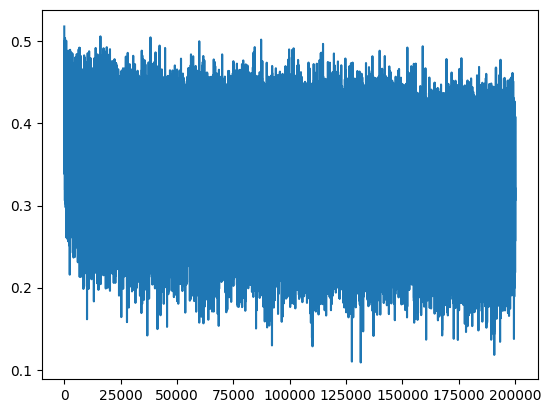

In [50]:
plt.plot(lossi)

# STARTER CODE END

One thing to note: our batch size is very small right now (32 elements). This means that the variance in our losses will be high. In order to get a better representation of the loss, we could consider using a larger batch-size (resulting in a smoother curve), or represent loss as an average to filter out a lot of the noise we see in the plot above. We will address that shortly.


First, we can analyze how the starter code performs once the model is trained. We will need to make sure to set our batchnorm layers to eval mode:

In [51]:
for layer in layers:
    layer.training=False

@torch.no_grad()
def split_loss(split):
    x,y = {
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xte, Yte)
    }[split]

    emb = C[x]
    x = emb.view(emb.shape[0], -1)
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, y)
    print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.0583250522613525
val 2.1065289974212646


We can also generate some sample names from the model -- at this point our names are starting to look somewhat reasonable!

In [52]:
# sample from the model
for _ in range(20):
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
         # forward pass the neural net
        emb = C[torch.tensor([context])]
      
        x = emb.view(emb.shape[0], -1)
        for layer in layers:
            x = layer(x)
        logits = x
        probs = F.softmax(logits, dim=1)
        # sample from the distribution
        ix = torch.multinomial(probs, num_samples=1).item()
        # shift the context window and track the samples
        context = context[1:] + [ix]
        out.append(ix)
        # if we sample the special '.' token, break
        if ix == 0:
            break
    
    print(''.join(itos[i] for i in out)) # decode and print the generated word

ivon.
fanili.
thoommara.
kelo.
matyn.
leandr.
aleigh.
koldeniah.
prus.
carleen.
jah.
jorra.
alaya.
shonan.
vishylaharia.
juna.
vio.
orven.
mina.
laylee.


To fix the loss plot, one very simple fix is to change the shape of our loss tensor such that we organize it into uniform-sized rows. Then, we can take the mean of each row of consecutive elements to get a smoother curve.

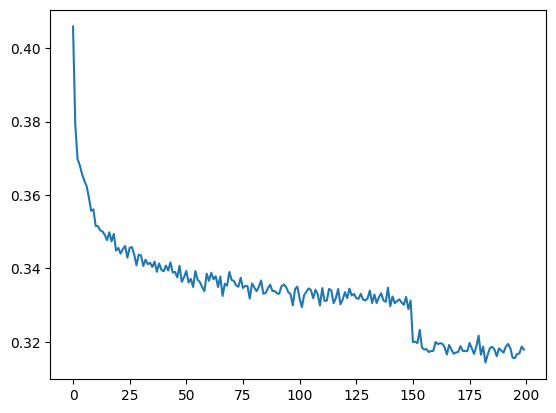

In [53]:
chunk_size = 1000

plt.plot(torch.tensor(lossi).view(-1,chunk_size).mean(1))

Next up, we can continue to organize our forward progation code into modules, right now we have to write 5 lines of code to propagate our data through the network and calculate loss. If we do a better job of organizing we can make that much nicer.

First, we can create modules for the embedding and flatten operations we perform via:
```
emb = C[x]
x = emb.view(emb.shape[0], -1)
```
We can achieve this by just compartmentalizing those operations into simple modules -- this way they become more composable with the modules we've already defined

In [63]:
class Embedding:
    def __init__(self, num_embeddings, embedding_dim) -> None:
        self.weight = torch.randn((num_embeddings, embedding_dim))
    def __call__(self, IX):
        self.out = self.weight[IX]
        return self.out
    def parameters(self):
        return [self.weight]
    
class Flatten:
    def __call__(self, x):
        self.out = x.view(x.shape[0], -1)
        return self.out
    def parameters(self):
        return []

Then, we can modify our network initialization and forward pass code to use these new modules

In [64]:
# initialization

torch.manual_seed(42); # seed rng for reproducibility
# original network
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

layers = [
  Embedding(vocab_size, n_embd), # add the new modules!
  Flatten(),
  Linear(n_embd * block_size, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(n_hidden, vocab_size)
]


# parameter init
with torch.no_grad():
  layers[-1].weight *= 0.1 # last layer make less confident

parameters = [p for layer in layers for p in layer.parameters()] # now we don't need to handle embedding parameters with a special case 
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

# forward pass
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
  
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,))
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
  
  # forward pass
  x = Xb
  for layer in layers:
    x = layer(x)
  loss = F.cross_entropy(x, Yb) # loss function
  
  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update: simple SGD
  lr = 0.1 if i < 150000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())

12097
      0/ 200000: 3.2966
  10000/ 200000: 2.2322
  20000/ 200000: 2.4111
  30000/ 200000: 2.1004
  40000/ 200000: 2.3157
  50000/ 200000: 2.2104
  60000/ 200000: 1.9653
  70000/ 200000: 1.9767
  80000/ 200000: 2.6738
  90000/ 200000: 2.0837
 100000/ 200000: 2.2730
 110000/ 200000: 1.7491
 120000/ 200000: 2.2891
 130000/ 200000: 2.3443
 140000/ 200000: 2.1731
 150000/ 200000: 1.8246
 160000/ 200000: 1.7614
 170000/ 200000: 2.2419
 180000/ 200000: 2.0803
 190000/ 200000: 2.1326


Another way we can make our implementation more elegant is using a *container*, which is a notion pytorch uses to describe a module that is composed of other modules. We can write a simple 'Sequential' module, which threads its input through each of its contained layers in order.

In [ ]:
class Sequential:
    def __init__(self, layers) -> None:
        self.layers = layers
    
    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        
        self.out = x
        return self.out
    
    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]

Then, we can update our network init and forward pass once more:

In [65]:
# initialization

torch.manual_seed(42); # seed rng for reproducibility
# original network
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

model = Sequential([
  Embedding(vocab_size, n_embd), # add the new modules!
  Flatten(),
  Linear(n_embd * block_size, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(n_hidden, vocab_size)
])


# parameter init
with torch.no_grad():
  model.layers[-1].weight *= 0.1 # last layer make less confident


print(sum(p.nelement() for p in model.parameters())) # number of parameters in total
for p in model.parameters():
  p.requires_grad = True

# forward pass
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
  
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,))
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
  
  # forward pass
  x = model(Xb)
  loss = F.cross_entropy(x, Yb) # loss function
  
  # backward pass
  for p in model.parameters():
    p.grad = None
  loss.backward()
  
  # update: simple SGD
  lr = 0.1 if i < 150000 else 0.01 # step learning rate decay
  for p in model.parameters():
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())

12097
      0/ 200000: 3.2966
  10000/ 200000: 2.2322
  20000/ 200000: 2.4111
  30000/ 200000: 2.1004
  40000/ 200000: 2.3157
  50000/ 200000: 2.2104
  60000/ 200000: 1.9653
  70000/ 200000: 1.9767
  80000/ 200000: 2.6738
  90000/ 200000: 2.0837
 100000/ 200000: 2.2730
 110000/ 200000: 1.7491
 120000/ 200000: 2.2891
 130000/ 200000: 2.3443
 140000/ 200000: 2.1731
 150000/ 200000: 1.8246
 160000/ 200000: 1.7614
 170000/ 200000: 2.2419
 180000/ 200000: 2.0803
 190000/ 200000: 2.1326


We also need to update our evaluation and sampling code:

In [66]:
for layer in model.layers:
    layer.training=False

@torch.no_grad()
def split_loss(split):
    x,y = {
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xte, Yte)
    }[split]
    x = model(x)
    loss = F.cross_entropy(x, y)
    print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.0583250522613525
val 2.1065289974212646


In [71]:
# sample from the model
for _ in range(20):
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
         # forward pass the neural net
      
        x = model(torch.tensor([context]))
        probs = F.softmax(x, dim=1)
        # sample from the distribution
        ix = torch.multinomial(probs, num_samples=1).item()
        # shift the context window and track the samples
        context = context[1:] + [ix]
        out.append(ix)
        # if we sample the special '.' token, break
        if ix == 0:
            break
    
    print(''.join(itos[i] for i in out)) # decode and print the generated word

miah.
vishylaharia.
juna.
vio.
orven.
mina.
laylee.
esreezeal.
wyla.
bord.
ser.
apgbe.
saan.
krison.
jevellrah.
rid.
jayden.
layx.
syrias.
cir.


In order to improve the model, one thing we could try is using a larger context size (block_size) when predicting the next character. We can try increasing the block size from 3 up to 8:

In [72]:
# build the dataset
block_size = 8 # context length: how many characters do we take to predict the next one?

def build_dataset(words):  
  X, Y = [], []
  
  for w in words:
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

n1 = int(0.8*len(words))
n2 = int(0.9*len(words))
Xtr,  Ytr  = build_dataset(words[:n1])     # 80%
Xdev, Ydev = build_dataset(words[n1:n2])   # 10%
Xte,  Yte  = build_dataset(words[n2:])     # 10%

torch.manual_seed(42); # seed rng for reproducibility
# original network
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

model = Sequential([
  Embedding(vocab_size, n_embd), # add the new modules!
  Flatten(),
  Linear(n_embd * block_size, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(n_hidden, vocab_size)
])


# parameter init
with torch.no_grad():
  model.layers[-1].weight *= 0.1 # last layer make less confident


print(sum(p.nelement() for p in model.parameters())) # number of parameters in total
for p in model.parameters():
  p.requires_grad = True

# forward pass
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
  
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,))
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
  
  # forward pass
  x = model(Xb)
  loss = F.cross_entropy(x, Yb) # loss function
  
  # backward pass
  for p in model.parameters():
    p.grad = None
  loss.backward()
  
  # update: simple SGD
  lr = 0.1 if i < 150000 else 0.01 # step learning rate decay
  for p in model.parameters():
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())

torch.Size([182625, 8]) torch.Size([182625])
torch.Size([22655, 8]) torch.Size([22655])
torch.Size([22866, 8]) torch.Size([22866])
22097
      0/ 200000: 3.2847
  10000/ 200000: 2.0647
  20000/ 200000: 1.9722
  30000/ 200000: 2.0948
  40000/ 200000: 1.9738
  50000/ 200000: 2.1287
  60000/ 200000: 2.3574
  70000/ 200000: 1.9131
  80000/ 200000: 2.0735
  90000/ 200000: 2.0968
 100000/ 200000: 1.4963
 110000/ 200000: 2.1294
 120000/ 200000: 2.2324
 130000/ 200000: 2.2071
 140000/ 200000: 2.2326
 150000/ 200000: 1.8908
 160000/ 200000: 1.6867
 170000/ 200000: 2.0968
 180000/ 200000: 1.7824
 190000/ 200000: 1.9151


In [73]:
for layer in model.layers:
    layer.training=False

@torch.no_grad()
def split_loss(split):
    x,y = {
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xte, Yte)
    }[split]
    x = model(x)
    loss = F.cross_entropy(x, y)
    print(split, loss.item())

split_loss('train')
split_loss('val')

train 1.9163438081741333
val 2.034247636795044


While we see some improvement with this larger block size, we still are ultimately combinining the context together in a single step, which might be something that would be better to do more incrementally.


Instead, we can implement WaveNet, which uses a heirarchical structure to combine context elements over the course of many layers, while maintaining some notion of locality amongst context inputs. https://arxiv.org/abs/1609.03499

In order to implement this structure, we need to join pairs of elements in each layer. In our MLP example, we join every input element in the first layer, via flattening the encodings and feeding the result into a linear layer. Instead, we need to create groups for each pair, such that the neurons that each group feed into are isolated from other groups.

In practice, instead of our flatten layer resulting in a tensor of the shape (X, 80)...

In [74]:
model.layers[1].out.shape 

(torch.Size([22655, 8, 10]), torch.Size([22655, 80]))

We want (X, 4, 20) for 4 groups of two from a block of 8 inputs.

In [76]:
model.layers[1].out.view(-1, 4, 20).shape

torch.Size([22655, 4, 20])

We can implement a new Flatten layer that gives the desired behavior:

In [77]:
class FlattenConsecutive:
    # flattens n consecutive elements
    def __init__(self, n) -> None:
        self.n = n
    
    def __call__(self, x):

        B, T, C = x.shape
        # we still want the B samples in the batch, but instead of T embeddings of size C concatenated toghether, we want to concatenate each of n groups of consecutive embeddings
        x = x.view(B, T//self.n, C*self.n) 
        # if this results in only 1 group, that dimension is unnessecary
        if x.shape[1] == 1:
            x = x.squeeze(1) # remove the extra dimension

        self.out = x
        return self.out
    
    def parameters(self):
        return []

Then, we can test it with n == block_size, this should yield the same behavior as before:

In [83]:

n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

model = Sequential([
  Embedding(vocab_size, n_embd), # add the new modules!
  FlattenConsecutive(block_size),
  Linear(n_embd * block_size, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(n_hidden, vocab_size)
])


# parameter init
with torch.no_grad():
  model.layers[-1].weight *= 0.1 # last layer make less confident


print(sum(p.nelement() for p in model.parameters())) # number of parameters in total
for p in model.parameters():
  p.requires_grad = True

22097


We can then run a small example through the network to see that our output shapes after each layer are as we expect them to be:

In [84]:
ix = torch.randint(0, Xtr.shape[0], (4,))
Xb, Yb = Xtr[ix], Ytr[ix]
logits = model(Xb)

for layer in model.layers:
    print(layer.__class__.__name__, ':', tuple(layer.out.shape))

Embedding : (4, 8, 10)
FlattenConsecutive : (4, 80)
Linear : (4, 200)
BatchNorm1d : (4, 200)
Tanh : (4, 200)
Linear : (4, 27)


Next let's update the group size to be smaller than the block size. We can reduce the number of groups until we have a single group remaining, so 4 groups, then 2, then 1

In [89]:

torch.manual_seed(42); # seed rng for reproducibility
# original network
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP
group_size = 2

model = Sequential([
  Embedding(vocab_size, n_embd), # add the new modules!
  FlattenConsecutive(group_size),
  Linear(n_embd * group_size, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  FlattenConsecutive(group_size),
  Linear(n_hidden * group_size, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  FlattenConsecutive(group_size),
  Linear(n_hidden * group_size, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(n_hidden, vocab_size)
])


# parameter init
with torch.no_grad():
  model.layers[-1].weight *= 0.1 # last layer make less confident


print(sum(p.nelement() for p in model.parameters())) # number of parameters in total
for p in model.parameters():
  p.requires_grad = True

170897


We can see that our implementation yields the desired group sizes as we propagate through the layers, we divide out 8 embeddings into groups of two until we have a single group -- acheiving the heirarchical WaveNet architecture:

In [92]:
ix = torch.randint(0, Xtr.shape[0], (4,))
Xb, Yb = Xtr[ix], Ytr[ix]
logits = model(Xb)


for layer in model.layers:
    print(layer.__class__.__name__, ':', tuple(layer.out.shape))

Embedding : (4, 8, 10)
FlattenConsecutive : (4, 4, 20)
Linear : (4, 4, 200)
BatchNorm1d : (4, 4, 200)
Tanh : (4, 4, 200)
FlattenConsecutive : (4, 2, 400)
Linear : (4, 2, 200)
BatchNorm1d : (4, 2, 200)
Tanh : (4, 2, 200)
FlattenConsecutive : (4, 400)
Linear : (4, 200)
BatchNorm1d : (4, 200)
Tanh : (4, 200)
Linear : (4, 27)


One adjustment we can make is scaling down the number of parameters... we can preserve the heirarchical structure while reducing the number of parameters to be closer to the number we had with the MLP implementation... at 170k we've almost 8x-ed the number of parameters in our network

In [100]:

torch.manual_seed(42); # seed rng for reproducibility
# original network
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 68 # the number of neurons in the hidden layer of the MLP
group_size = 2

model = Sequential([
  Embedding(vocab_size, n_embd), # add the new modules!
  FlattenConsecutive(group_size),
  Linear(n_embd * group_size, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  FlattenConsecutive(group_size),
  Linear(n_hidden * group_size, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  FlattenConsecutive(group_size),
  Linear(n_hidden * group_size, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(n_hidden, vocab_size)
])


# parameter init
with torch.no_grad():
  model.layers[-1].weight *= 0.1 # last layer make less confident


print(sum(p.nelement() for p in model.parameters())) # number of parameters in total
for p in model.parameters():
  p.requires_grad = True

ix = torch.randint(0, Xtr.shape[0], (4,))
Xb, Yb = Xtr[ix], Ytr[ix]
logits = model(Xb)


for layer in model.layers:
    print(layer.__class__.__name__, ':', tuple(layer.out.shape))

22397
Embedding : (4, 8, 10)
FlattenConsecutive : (4, 4, 20)
Linear : (4, 4, 68)
BatchNorm1d : (4, 4, 68)
Tanh : (4, 4, 68)
FlattenConsecutive : (4, 2, 136)
Linear : (4, 2, 68)
BatchNorm1d : (4, 2, 68)
Tanh : (4, 2, 68)
FlattenConsecutive : (4, 136)
Linear : (4, 68)
BatchNorm1d : (4, 68)
Tanh : (4, 68)
Linear : (4, 27)


With a hidden layer size of 68 we have exactly the number of parameters we had before! Next we can test that this implementation is still effective:

In [101]:
# forward pass
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
  
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,))
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
  
  # forward pass
  x = model(Xb)
  loss = F.cross_entropy(x, Yb) # loss function
  
  # backward pass
  for p in model.parameters():
    p.grad = None
  loss.backward()
  
  # update: simple SGD
  lr = 0.1 if i < 150000 else 0.01 # step learning rate decay
  for p in model.parameters():
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())

      0/ 200000: 3.3068
  10000/ 200000: 2.1772
  20000/ 200000: 2.4289
  30000/ 200000: 2.2455
  40000/ 200000: 2.0728
  50000/ 200000: 2.1918
  60000/ 200000: 2.1698
  70000/ 200000: 1.8329
  80000/ 200000: 1.9106
  90000/ 200000: 1.9519
 100000/ 200000: 1.7333
 110000/ 200000: 2.4024
 120000/ 200000: 2.2626
 130000/ 200000: 2.0729
 140000/ 200000: 2.2658
 150000/ 200000: 1.9702
 160000/ 200000: 2.1914
 170000/ 200000: 2.1956
 180000/ 200000: 2.0618
 190000/ 200000: 1.9979


In [102]:
for layer in model.layers:
    layer.training=False

@torch.no_grad()
def split_loss(split):
    x,y = {
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xte, Yte)
    }[split]
    x = model(x)
    loss = F.cross_entropy(x, y)
    print(split, loss.item())

split_loss('train')
split_loss('val')

train 1.9448806047439575
val 2.0309791564941406


This is nearly identical to our MLP's performance -- but we have an issue that needs to be addressed: we have not updated our BatchNorm layer to handle its new input shape.

If we take a look at the statistics tracked by the first BatchNorm layer, we can see that they take on the shape (1,4,num_channels) whereas before they took on the shape (1,num_channels).
So instead of computing the mean/var for each channel, we instead are computing the mean/variance for each group in each channel! However, we'd rather maintain statstics over the entire batch rather than subsections of the batch. It is not useful to compute means/var for each group rather than across the entire batch -- and computing across a larger set of samples means that our statistics will be more stable/accurate!

In [105]:
model.layers[3].running_mean.shape, model.layers[3].running_var.shape

(torch.Size([1, 4, 68]), torch.Size([1, 4, 68]))

We can update our BatchNorm layer to fix this issue:

In [106]:
class BatchNorm1d:
  def __init__(self, dim, eps=1e-5, momentum=0.1):
    self.eps = eps
    self.momentum = momentum
    self.training = True
    # parameters (trained with backprop)
    self.gamma = torch.ones(dim)
    self.beta = torch.zeros(dim)
    # buffers (trained with a running 'momentum update')
    self.running_mean = torch.zeros(dim)
    self.running_var = torch.ones(dim)
  
  def __call__(self, x):
    # calculate the forward pass
    if self.training:
      # compute statistics over every dimensions except for channels
      if x.ndim == 2:
        dim = (0,)
      elif x.ndim == 3: 
        dim = (0, 1)

      xmean = x.mean(dim, keepdim=True) # batch mean
      xvar = x.var(dim, keepdim=True) # batch variance
    else:
      xmean = self.running_mean
      xvar = self.running_var
    xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize to unit variance
    self.out = self.gamma * xhat + self.beta
    # update the buffers
    if self.training:
      with torch.no_grad():
        self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
        self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
    return self.out
  
  def parameters(self):
    return [self.gamma, self.beta]


In [111]:

torch.manual_seed(42); # seed rng for reproducibility
# original network
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 68 # the number of neurons in the hidden layer of the MLP
group_size = 2

model = Sequential([
  Embedding(vocab_size, n_embd), # add the new modules!
  FlattenConsecutive(group_size),
  Linear(n_embd * group_size, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  FlattenConsecutive(group_size),
  Linear(n_hidden * group_size, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  FlattenConsecutive(group_size),
  Linear(n_hidden * group_size, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(n_hidden, vocab_size)
])


# parameter init
with torch.no_grad():
  model.layers[-1].weight *= 0.1 # last layer make less confident


print(sum(p.nelement() for p in model.parameters())) # number of parameters in total
for p in model.parameters():
  p.requires_grad = True

ix = torch.randint(0, Xtr.shape[0], (4,))
Xb, Yb = Xtr[ix], Ytr[ix]
logits = model(Xb)


for layer in model.layers:
    print(layer.__class__.__name__, ':', tuple(layer.out.shape))

22397
Embedding : (4, 8, 10)
FlattenConsecutive : (4, 4, 20)
Linear : (4, 4, 68)
BatchNorm1d : (4, 4, 68)
Tanh : (4, 4, 68)
FlattenConsecutive : (4, 2, 136)
Linear : (4, 2, 68)
BatchNorm1d : (4, 2, 68)
Tanh : (4, 2, 68)
FlattenConsecutive : (4, 136)
Linear : (4, 68)
BatchNorm1d : (4, 68)
Tanh : (4, 68)
Linear : (4, 27)


In [112]:
model.layers[3].running_mean.shape, model.layers[3].running_var.shape

(torch.Size([1, 1, 68]), torch.Size([1, 1, 68]))

In [113]:
# forward pass
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
  
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,))
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
  
  # forward pass
  x = model(Xb)
  loss = F.cross_entropy(x, Yb) # loss function
  
  # backward pass
  for p in model.parameters():
    p.grad = None
  loss.backward()
  
  # update: simple SGD
  lr = 0.1 if i < 150000 else 0.01 # step learning rate decay
  for p in model.parameters():
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())

      0/ 200000: 3.3109
  10000/ 200000: 2.1318
  20000/ 200000: 2.3410
  30000/ 200000: 2.2023
  40000/ 200000: 2.0870
  50000/ 200000: 2.2679
  60000/ 200000: 2.0068
  70000/ 200000: 1.9561
  80000/ 200000: 1.9424
  90000/ 200000: 1.7969
 100000/ 200000: 1.6260
 110000/ 200000: 2.3590
 120000/ 200000: 2.4077
 130000/ 200000: 2.0557
 140000/ 200000: 2.2412
 150000/ 200000: 1.9585
 160000/ 200000: 2.0717
 170000/ 200000: 2.2240
 180000/ 200000: 1.9862
 190000/ 200000: 1.9365
